## Fine-tuned Mobilenet

Dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset

- 10 classes (digits 0-9)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools, os, random, shutil, glob
import matplotlib.pyplot as plt
%matplotlib inline

#### Image preparation

In [10]:
#Organize data into train, valid, test dirs
os.chdir('data/Sign-Language-Digits-Dataset/')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10): #we have 10 directories (0-9)
        shutil.move(f'{i}', 'train') #move each of these directories in the 'train' directory
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for j in test_samples:
            shutil.move(f'train/{i}/{j}', f'test/{i}')
os.chdir('../..')

In [1]:
train_path = 'data/Sign-Language-Digits-Dataset/train/'
valid_path = 'data/Sign-Language-Digits-Dataset/valid/'
test_path = 'data/Sign-Language-Digits-Dataset/test/'

In [5]:
#resize images to 224x224 pixels
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [6]:
#veryfing if the found statements are indeed the case (assert = beweren)
assert train_batches.n == 1712 
assert valid_batches.n == 300 
assert test_batches.n == 50 
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

#### Modify Model

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [10]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

Sequential vs Functional Model:

- in sequential model you can only stack one layer after another, while in functional model you can connect a layer to literally any other layer.

In [25]:
x = mobile.layers[-5].output #take all up untill the last 5 layers (5 found through experimentation)
x = tf.keras.layers.Flatten()(x)
output = Dense(units=10, activation='softmax')(x) #functional model type

In [26]:
model = Model(inputs=mobile.input, outputs=output)

In [27]:
#freeze all layers before the 23th layer
for layer in model.layers[:-23]: #(23 found through experimentation)
    layer.trainable = False #make them not trainable

In [28]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

### Train the model

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(x=train_batches,
          validation_data=valid_batches, 
          epochs=30,
          verbose=2)

Epoch 1/30
172/172 - 104s - loss: 0.6036 - accuracy: 0.8224 - val_loss: 0.3513 - val_accuracy: 0.8633 - 104s/epoch - 603ms/step
Epoch 2/30
172/172 - 48s - loss: 0.1260 - accuracy: 0.9761 - val_loss: 0.1211 - val_accuracy: 0.9733 - 48s/epoch - 279ms/step
Epoch 3/30
172/172 - 50s - loss: 0.0645 - accuracy: 0.9901 - val_loss: 0.0886 - val_accuracy: 0.9767 - 50s/epoch - 291ms/step
Epoch 4/30
172/172 - 51s - loss: 0.0319 - accuracy: 0.9982 - val_loss: 0.0832 - val_accuracy: 0.9833 - 51s/epoch - 296ms/step
Epoch 5/30
172/172 - 40s - loss: 0.0223 - accuracy: 0.9988 - val_loss: 0.0682 - val_accuracy: 0.9833 - 40s/epoch - 231ms/step
Epoch 6/30
172/172 - 41s - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0614 - val_accuracy: 0.9867 - 41s/epoch - 239ms/step
Epoch 7/30
172/172 - 45s - loss: 0.0115 - accuracy: 0.9994 - val_loss: 0.0564 - val_accuracy: 0.9833 - 45s/epoch - 259ms/step
Epoch 8/30
172/172 - 45s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0471 - val_accuracy: 0.9833 - 45s/epoch - 2

#### Predict sign language digits

In [31]:
test_labels = test_batches.classes

In [32]:
predictions = model.predict(x=test_batches, verbose=0)

In [33]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [34]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 1 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 2 3 0]
 [0 0 0 0 0 0 0 0 0 5]]


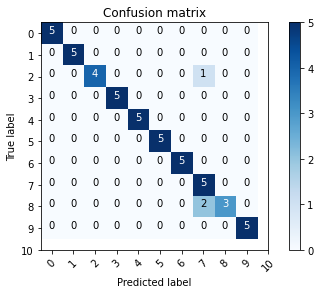

In [38]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9','10']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)